# Convolutional AE on MNIST

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import tensorflow as tf
import tensorflow_quantum as tfq
from hep_VQAE import data_preprocessing as dp
from hep_VQAE import CAE as cae
from tensorflow.keras import layers, losses

import warnings
warnings.filterwarnings('ignore')

2022-07-18 19:23:35.409994: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-18 19:23:35.410019: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/tom/.conda/envs/tfq/lib/python3.9/site-packages/cirq/ops/gateset.py:376: UserWarning: v0.14.1 is the last release `cirq.GlobalPhaseGate` is included by default. If you were relying on this behavior, you can include a `cirq.GlobalPhaseGate` in your `*gates`. If not, then you can ignore this warning. It will be removed in v0.16
  warnings.warn(
2022-07-18 19:23:36.618769: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-18 19:23:36.618788: W tensorflow/

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train/255.0, x_test/255.0

In [3]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


In [4]:
num_data, input_dim_x, input_dim_y = x_train.shape
input_dim = input_dim_x, input_dim_y
input_dim

(28, 28)

In [5]:
latent_dim = 1
ae = cae.Convolutional_Autoencoder1(input_dim)

In [6]:
ae.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.001))

In [7]:
ae.build(x_train.shape)
ae.summary()

Model: "convolutional__autoencoder1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 45)                40269     
                                                                 
 sequential_1 (Sequential)   (12049, 28, 28, 1)        51345     
                                                                 
Total params: 91,614
Trainable params: 91,614
Non-trainable params: 0
_________________________________________________________________


Summary of encoder and decoder model

In [8]:
ae.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 16)          4624      
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 45)                35325     
                                                                 
Total params: 40,269
Trainable params: 40,269
Non-trainable params: 0
_________________________________________________________________


In [9]:
ae.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (12049, 784)              36064     
                                                                 
 reshape (Reshape)           (12049, 7, 7, 16)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (12049, 14, 14, 16)      2320      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (12049, 28, 28, 32)      12832     
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (12049, 28, 28, 1)        129       
                                                                 
Total params: 51,345
Trainable params: 51,345
Non-trai

In [10]:
x_train_three = x_train[y_train==1]
x_train = x_train[y_train==0]

x_test_three = x_test[y_test==1]
x_test = x_test[y_test==0]

In [11]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
hist = ae.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[es])

Epoch 1/10
185/185 [==============================] - 5s 25ms/step - loss: 0.0756 - val_loss: 0.0579
Epoch 2/10
185/185 [==============================] - 5s 25ms/step - loss: 0.0490 - val_loss: 0.0426
Epoch 3/10
185/185 [==============================] - 4s 24ms/step - loss: 0.0374 - val_loss: 0.0347
Epoch 4/10
185/185 [==============================] - 4s 22ms/step - loss: 0.0304 - val_loss: 0.0260
Epoch 5/10
185/185 [==============================] - 4s 21ms/step - loss: 0.0231 - val_loss: 0.0208
Epoch 6/10
185/185 [==============================] - 4s 23ms/step - loss: 0.0184 - val_loss: 0.0160
Epoch 7/10
185/185 [==============================] - 4s 23ms/step - loss: 0.0147 - val_loss: 0.0135
Epoch 8/10
185/185 [==============================] - 4s 22ms/step - loss: 0.0126 - val_loss: 0.0120
Epoch 9/10
185/185 [==============================] - 4s 24ms/step - loss: 0.0112 - val_loss: 0.0109
Epoch 10/10
185/185 [==============================] - 4s 21ms/step - loss: 0.0101 - val_lo

In [12]:
ae.encoder(x_test[0].reshape(1,28,28,1))

<tf.Tensor: shape=(1, 45), dtype=float32, numpy=
array([[0.17321023, 0.41552663, 0.50255716, 0.94172233, 0.716668  ,
        0.3885963 , 0.42848706, 0.68789995, 0.15193576, 0.25013712,
        0.5093176 , 0.81688094, 0.9992987 , 0.5787027 , 0.66894853,
        0.3501999 , 0.11274949, 0.07962498, 0.90255773, 0.5501595 ,
        0.9969157 , 0.21529415, 0.4238843 , 0.9996036 , 0.5442602 ,
        0.9514159 , 0.78041506, 0.8038529 , 0.8792782 , 0.39775702,
        0.5962816 , 0.30912182, 0.25732952, 0.06678453, 0.45072076,
        0.59326416, 0.6946875 , 0.57852185, 0.19177926, 0.61862016,
        0.12505683, 0.7756173 , 0.7182825 , 0.48085544, 0.12559527]],
      dtype=float32)>

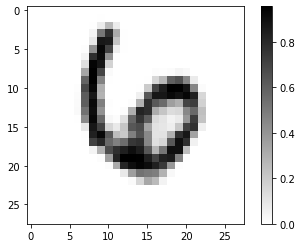

In [36]:
num = 2
plt.imshow(ae(x_test[num].reshape(1,28,28,1)).numpy().reshape((28,28)),cmap='binary')
plt.colorbar()

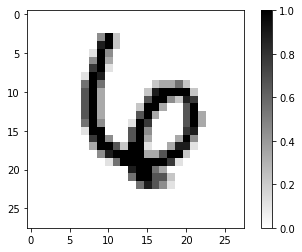

In [37]:
plt.imshow(x_test[num].reshape(28,28),cmap='binary')
plt.colorbar()

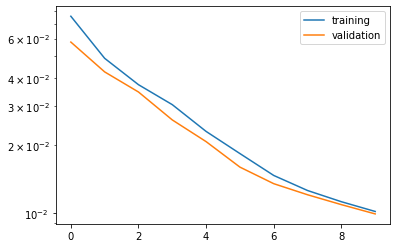

In [15]:
plt.plot(hist.history['loss'], label="training")
plt.plot(hist.history['val_loss'], label="validation")
plt.yscale('log')
plt.legend()

In [16]:
def mae(x):
    pred = ae.predict(x)
    pred = pred.reshape(pred.shape[:-1])
    return np.mean(np.abs(x - pred)**2,axis=(1,2))

def recon_acc(x):
    return 1 - mae(x)

In [17]:
sixes = recon_acc(x_test)
threes = recon_acc(x_test_three)

0.9912885998853163
0.9551344750629684


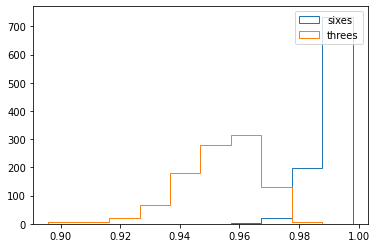

In [18]:
print(np.median(sixes))
bins = np.histogram(np.hstack((sixes, threes)), bins=10)[1]
plt.hist(sixes, histtype='step', label="sixes",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
print(np.median(threes))
plt.hist(threes, histtype='step', label="threes",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
plt.legend()

0.9776422764227642


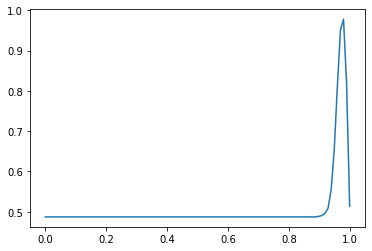

In [19]:
def acc_for_threshold(T):
    # sixes that are predicted six
    num_six_right = np.sum(sixes > T)
    # threes that are predicted three
    num_three_right = np.sum(threes < T)
    acc = (num_six_right + num_three_right)/(len(sixes) + len(threes))
    return acc

Ts = np.linspace(0,1,100)
accs = []
for i in Ts:
    accs.append(acc_for_threshold(i))
print(max(accs))
plt.plot(Ts, accs)  

In [20]:
from hep_VQAE import utils as ut

In [32]:
ut.test_collapse(x_test[:100], ae.predict(x_test[:100]))

0.8816101996544788

In [31]:
tf.image.ssim(x_test[:100].reshape(100,28,28,1).astype('float64'),ae(x_test[:100].reshape(100,28,28,1)).numpy().astype('float64'),max_val=1.0)

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([0.81492984, 0.9187862 , 0.88068426, 0.9405544 , 0.7808372 ,
       0.82870805, 0.8893686 , 0.90532976, 0.93923855, 0.74176687,
       0.81343764, 0.8740729 , 0.92305416, 0.9201576 , 0.92675096,
       0.8742643 , 0.88834184, 0.9303781 , 0.88548636, 0.93676174,
       0.9057481 , 0.81605256, 0.70483524, 0.8678423 , 0.8140354 ,
       0.80620784, 0.65868735, 0.9061133 , 0.93871504, 0.735408  ,
       0.83069396, 0.93226993, 0.8916218 , 0.9542439 , 0.87391144,
       0.58429956, 0.92823756, 0.91236603, 0.8570781 , 0.8383068 ,
       0.94666535, 0.8777528 , 0.87303776, 0.8370248 , 0.81611377,
       0.8950455 , 0.92157114, 0.90537816, 0.8392854 , 0.9399206 ,
       0.8906948 , 0.92558646, 0.91678023, 0.9086797 , 0.9208187 ,
       0.9724559 , 0.8047745 , 0.91061074, 0.89781064, 0.93736255,
       0.9226483 , 0.8832482 , 0.92241347, 0.89685655, 0.85244316,
       0.91228193, 0.8902674 , 0.77909553, 0.9411553 , 0.8274557 ,
       0.94210

In [48]:
MAE = tf.reduce_mean(tf.abs(x_test[:100].reshape(100,28,28,1) - ae(x_test[:100].reshape(100,28,28,1)).numpy())/tf.reduce_sum(x_test[:100],axis=(1,2)).numpy().reshape(100,1,1,1))

In [49]:
MAE

<tf.Tensor: shape=(), dtype=float64, numpy=0.00038227629087593133>